In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game

## Check that gradients can flow across channel:

In [3]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[2.3398214e-04 1.5049332e-02 9.8158669e-01 3.1299077e-03]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[2.9103830e-11, 1.8626451e-09, 1.1920929e-07, 4.6566129e-10]],
      dtype=float32)>

In [4]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [7]:
inputs, targets = generate_train_batch()

In [8]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

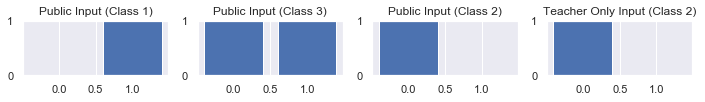

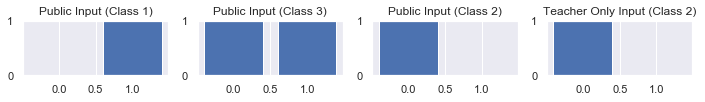

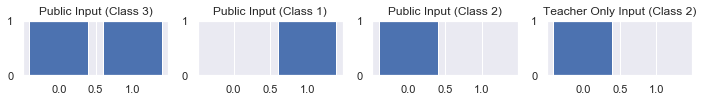

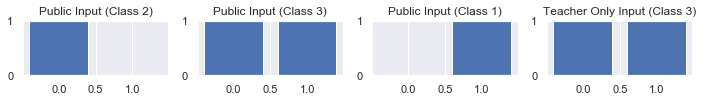

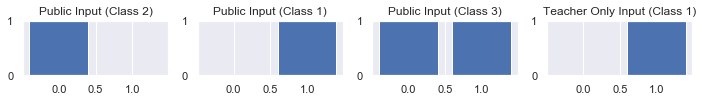

In [9]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [10]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[4, 2, 3, 0],
       [4, 2, 3, 1],
       [1, 3, 0, 2],
       [2, 3, 0, 4],
       [3, 4, 2, 1]], dtype=int64)>

## Create Data-Specific Input Encoder

In [11]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [12]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        p_mutate=0.5)

    loss = combined_loss_fn(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 0.07453244924545288
agent/dense/bias:0 teacher grad norm: 0.060664065182209015
agent/lstm/kernel:0 teacher grad norm: 0.10969773679971695
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.01840747892856598
agent/lstm/bias:0 teacher grad norm: 0.05149189755320549
agent/dense_1/kernel:0 teacher grad norm: 0.044563278555870056
agent/dense_1/bias:0 teacher grad norm: 0.05579795315861702

agent/dense_2/kernel:0 student grad norm: 0.0070133935660123825
agent/dense_2/bias:0 student grad norm: 0.01387658342719078
agent/lstm_1/kernel:0 student grad norm: 0.011313371360301971
agent/lstm_1/recurrent_kernel:0 student grad norm: 0.007729184813797474
agent/lstm_1/bias:0 student grad norm: 0.015135068446397781
agent/dense_3/kernel:0 student grad norm: 1.8545598983764648
agent/dense_3/bias:0 student grad norm: 2.519291400909424


In [13]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [14]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=0.5, 
                    training=False)

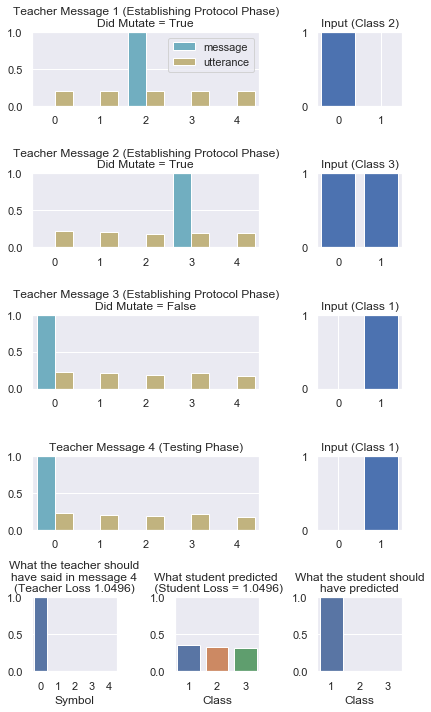

In [15]:
plot_game(inputs, outputs, targets, select_batch=1)

In [16]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 1.6248475313186646
agent/dense/bias:0 teacher grad norm: 1.3713613748550415
agent/lstm/kernel:0 teacher grad norm: 2.812843084335327
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.28128162026405334
agent/lstm/bias:0 teacher grad norm: 1.1025912761688232
agent/dense_1/kernel:0 teacher grad norm: 1.348278522491455
agent/dense_1/bias:0 teacher grad norm: 2.4507343769073486


# Run Experiments

In [17]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 0}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o)
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn
    )

In [18]:
experiment = create_self_play_experiment()
print(experiment.get_config())

{'max_epochs': 40, 'steps_per_epoch': 50, 'epochs_optimised': 0, 'loss_fn': 'complete_loss_fn', 'play_params': {'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.01, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}


In [19]:
experiment.train()

Epoch 0, Time Taken (mm:ss): 0:39, Mean Loss: 3.815
Test Loss: 4.1, Ground Truth F1-Score: 0.326, Student Divergence: 12.484, Teacher Divergence: 3.264
Epoch 1, Time Taken (mm:ss): 0:40, Mean Loss: 3.781
Epoch 2, Time Taken (mm:ss): 0:43, Mean Loss: 3.856
Epoch 3, Time Taken (mm:ss): 0:38, Mean Loss: 3.79
Epoch 4, Time Taken (mm:ss): 0:32, Mean Loss: 3.814
Epoch 5, Time Taken (mm:ss): 0:37, Mean Loss: 3.311
Test Loss: 2.98, Ground Truth F1-Score: 0.55, Student Divergence: 13.027, Teacher Divergence: 1.733
Epoch 6, Time Taken (mm:ss): 0:42, Mean Loss: 2.748
Epoch 7, Time Taken (mm:ss): 0:43, Mean Loss: 2.789
Epoch 8, Time Taken (mm:ss): 0:40, Mean Loss: 2.588
Epoch 9, Time Taken (mm:ss): 0:33, Mean Loss: 2.254
Epoch 10, Time Taken (mm:ss): 0:26, Mean Loss: 2.287
Test Loss: 1.803, Ground Truth F1-Score: 0.694, Student Divergence: 18.442, Teacher Divergence: 0.584
Epoch 11, Time Taken (mm:ss): 0:33, Mean Loss: 1.884
Epoch 12, Time Taken (mm:ss): 0:32, Mean Loss: 1.632
Epoch 13, Time Taken

In [20]:
experiment2 = create_self_play_experiment()

In [21]:
experiment2.train()

Epoch 0, Time Taken (mm:ss): 0:40, Mean Loss: 3.835
Test Loss: 4.204, Ground Truth F1-Score: 0.35, Student Divergence: 12.368, Teacher Divergence: 3.506
Epoch 1, Time Taken (mm:ss): 0:37, Mean Loss: 3.832
Epoch 2, Time Taken (mm:ss): 0:35, Mean Loss: 3.772
Epoch 3, Time Taken (mm:ss): 0:33, Mean Loss: 3.868
Epoch 4, Time Taken (mm:ss): 0:34, Mean Loss: 3.822
Epoch 5, Time Taken (mm:ss): 0:37, Mean Loss: 3.75
Test Loss: 4.16, Ground Truth F1-Score: 0.361, Student Divergence: 0.6, Teacher Divergence: 4.05
Epoch 6, Time Taken (mm:ss): 0:30, Mean Loss: 3.754
Epoch 7, Time Taken (mm:ss): 0:30, Mean Loss: 3.592
Epoch 8, Time Taken (mm:ss): 0:37, Mean Loss: 2.817
Epoch 9, Time Taken (mm:ss): 0:39, Mean Loss: 2.545
Epoch 10, Time Taken (mm:ss): 0:33, Mean Loss: 2.554
Test Loss: 2.278, Ground Truth F1-Score: 0.646, Student Divergence: 12.42, Teacher Divergence: 4.231
Epoch 11, Time Taken (mm:ss): 0:53, Mean Loss: 2.393
Epoch 12, Time Taken (mm:ss): 0:34, Mean Loss: 1.979
Epoch 13, Time Taken (m

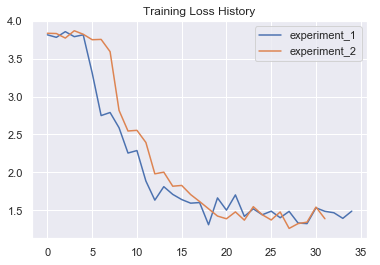

In [22]:
plt.figure()
plt.title('Training Loss History')
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='experiment_1');
sns.lineplot(x=range(len(experiment2.training_history)), 
             y=[item['loss'] for item in experiment2.training_history],
             label='experiment_2');

## Render Model Graph in Tensorboard

In [23]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)


# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [24]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [25]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.2330492734909058,
 'mean_ground_truth_f1': 0.94625,
 'mean_student_kld': 19.67424774169922,
 'mean_teacher_kld': 0.08059046417474747}

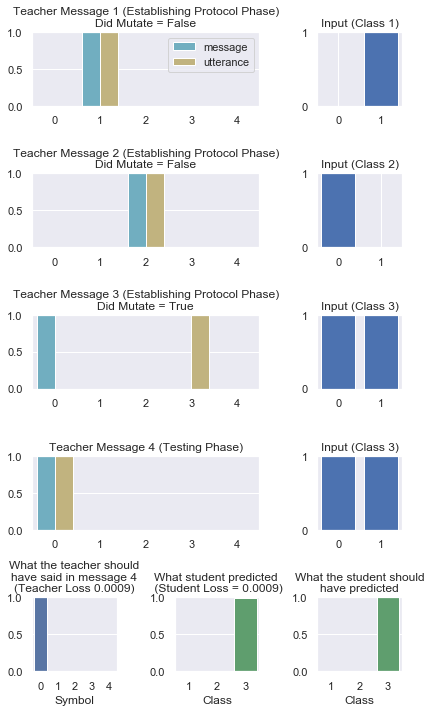

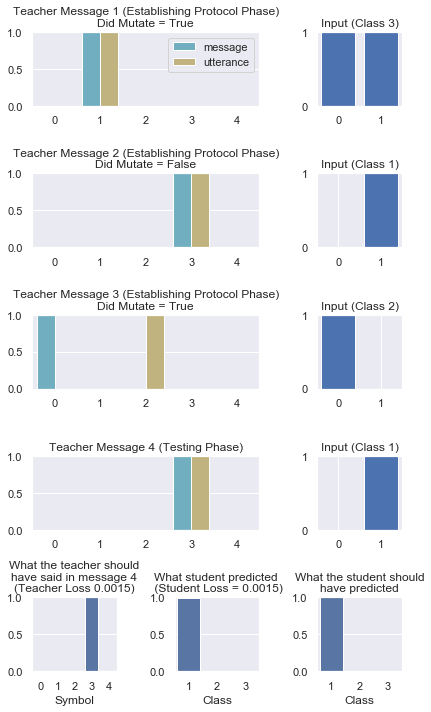

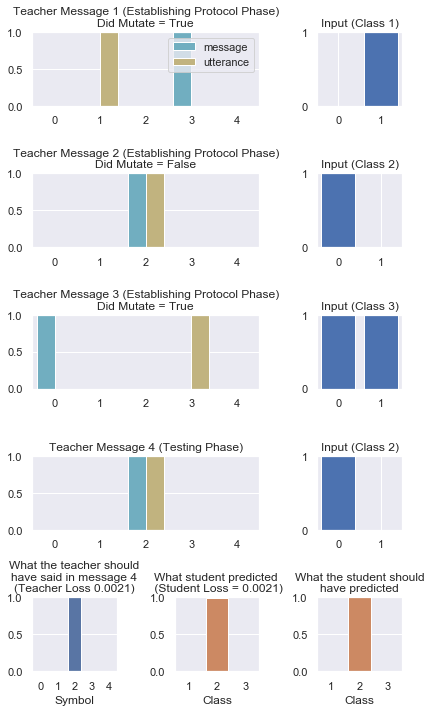

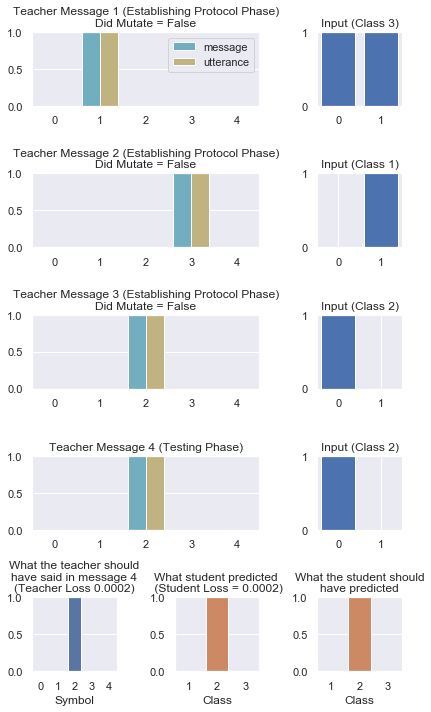

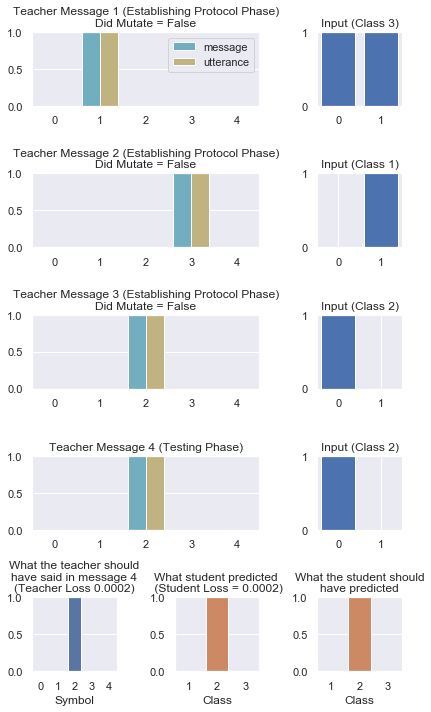

In [26]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [27]:
def compute_confusion_matrix(games_played):
    labels = tf.concat([
        tf.argmax(targets[-1], axis=-1) 
        for _, targets, _ in games_played
    ], axis=0)

    preds = tf.concat([
        tf.argmax(student_preds, axis=-1) 
        for _, _, (student_preds, _) in games_played
    ], axis=0)

    conf_matrix = tf.math.confusion_matrix(labels, preds)

    col_totals = tf.reduce_sum(conf_matrix, axis=0)
    col_totals = tf.repeat(col_totals, tf.shape(conf_matrix)[0])
    col_totals = tf.reshape(col_totals, tf.shape(conf_matrix))
    col_totals = tf.transpose(col_totals)

    conf_matrix = (conf_matrix / col_totals).numpy()
    conf_matrix[np.where(np.isnan(conf_matrix))] = 0
    
    return conf_matrix

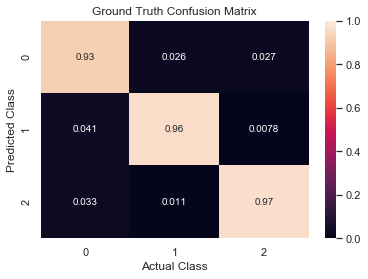

In [28]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

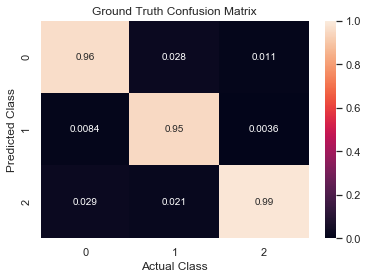

In [29]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

In [34]:
def make_map(label, message):
    *_, msg_size = tf.shape(message)
    lm_map_shape = (NUM_CLASSES, msg_size)
    class_indices = [i for i, _ in enumerate(class_labels)]
    indices = tf.reshape(tf.repeat(class_indices, msg_size), 
                         lm_map_shape)
    indices = tf.cast(indices, tf.int64) == label
    return message * tf.cast(indices, tf.float32)


def create_mean_class_message_map(games_played):
    """
    The mean label-message map is a representation of the 
    communication protocol being used for the test messages 
    being sent by the teacher. Each row correponds with a 
    class, each column corresponds with a symbol
    """
    messages = tf.concat([
        history[-1]['message_from_teacher'] 
        for *_, (_, history) in games_played
    ], axis=0)
    
    labels = tf.concat([
        tf.argmax(targets[-1], axis=-1) 
        for _, targets, _ in games_played
    ], axis=0)

    *_, msg_size = tf.shape(messages)
    lm_map = tf.zeros((NUM_CLASSES, msg_size))
    for label, message in zip(labels, messages):
        lm_map = lm_map + make_map(label, message)

    row_totals = tf.reduce_sum(lm_map, axis=1)
    row_totals = tf.repeat(row_totals, msg_size)
    row_totals = tf.reshape(row_totals, tf.shape(lm_map))

    return lm_map / row_totals

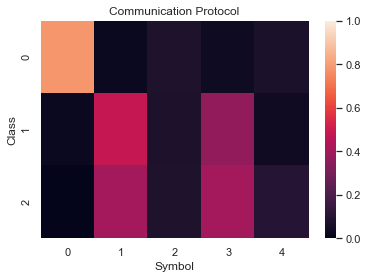

In [35]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

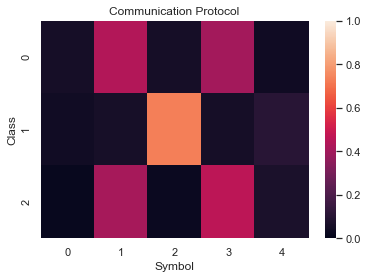

In [36]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

## Zero-shot Coordination

In [43]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)
teacher_error = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

Teacher Error: 0.0, Student Error: -1.611809580026602e-06, F1 Score 1.0, Loss: 1.157055377960205


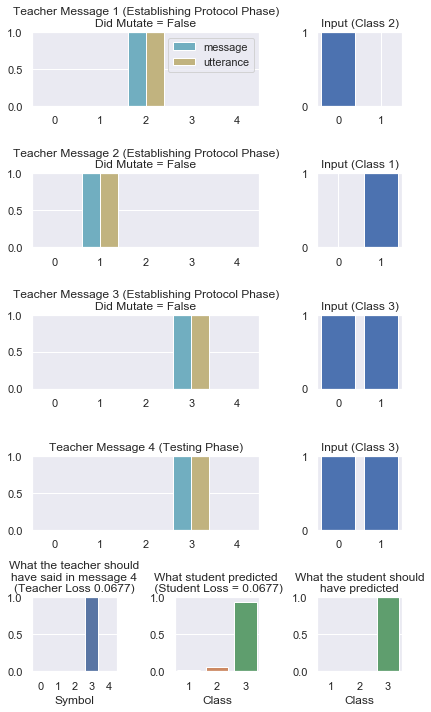

In [38]:
plot_game(inputs, outputs, targets, select_batch=1)

In [44]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)
teacher_error = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

Teacher Error: 0.0, Student Error: 32.23619079589844, F1 Score 1.0, Loss: 1.0593750476837158


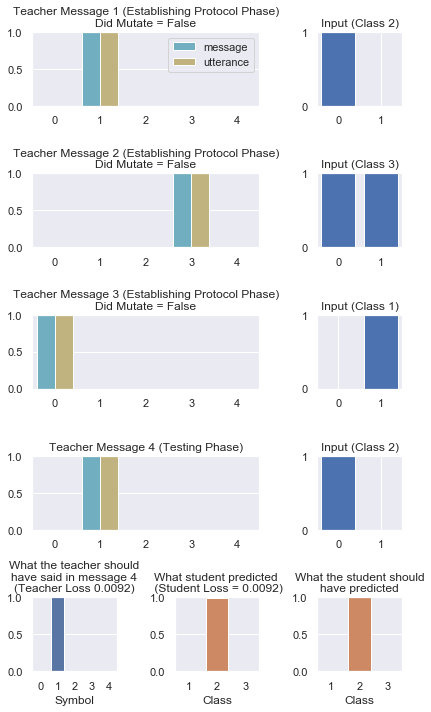

In [45]:
plot_game(inputs, outputs, targets)